# Analyzing patient data (extended version)

## Preliminaries

Load the required modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Data set description

The data consists of two spreadsheets.

The first is data on patients gathered during an experimental trial.  The patients' temperature is measured at one-hour intervals, and each hour, the patients receive a dose of a drug to reduce fever.  The first column is a patient ID, the second is the dose, the third the datetime information, and the fourth the body temperature.

The second spreadsheet is metadata on the patients.  The first column is the patient ID, which should be consistent with that in the first spreadsheet, the second column denotes the gender of the patient, the third an experimental condition.

## Experiment data

Read the data set as a pandas `DataFrame` from an Excel spreadsheet.  The data is in the file `patient_experiment.xlsx`.

In [2]:
experiment_data = pd.read_excel('data/patient_experiment.xlsx')

Let's explore the data set a bit.

In [3]:
experiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient      62 non-null     int64         
 1   dose         61 non-null     float64       
 2   date         62 non-null     datetime64[ns]
 3   temperature  61 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 2.1 KB


`data` contains 4 columns, and 62 rows, and there seems to be missing data for `dose` and `temperature` since these columns have only 61 entries.

Let's check the first few and last few rows.

In [4]:
experiment_data.head()

,patient,dose,date,temperature
0,1,0.0,2012-10-02 10:00:00,38.3
1,1,2.0,2012-10-02 11:00:00,38.5
2,1,2.0,2012-10-02 12:00:00,38.1
3,1,2.0,2012-10-02 13:00:00,37.3
4,1,0.0,2012-10-02 14:00:00,37.5


In [5]:
experiment_data.tail()

,patient,dose,date,temperature
57,9,12.0,2012-10-02 12:00:00,40.2
58,9,4.0,2012-10-02 13:00:00,39.1
59,9,4.0,2012-10-02 14:00:00,37.9
60,9,0.0,2012-10-02 15:00:00,37.1
61,9,0.0,2012-10-02 16:00:00,37.3


A very rough statistical overview is also useful.

In [6]:
experiment_data.describe()

,patient,dose,date,temperature
count,62.000000,61.000000,62,61.000000
mean,4.983871,2.278689,2012-10-02 12:57:05.806451200,37.881967
min,1.000000,0.000000,2012-10-02 10:00:00,35.900000
25%,3.000000,0.000000,2012-10-02 11:00:00,37.100000
50%,5.000000,1.000000,2012-10-02 13:00:00,37.700000
75%,7.000000,4.000000,2012-10-02 15:00:00,38.300000
max,9.000000,12.000000,2012-10-02 16:00:00,40.700000
std,2.620799,2.989599,NaN,1.081127


It seems that we have 9 patients, but lets verify that.

In [7]:
patients = experiment_data.patient.unique()
print(patients, '->', len(patients))

[1 2 3 4 5 6 7 8 9] -> 9


Let's check whether the number of measurements is equal for all 9 patients.

In [8]:
experiment_data[['patient', 'date']] \
    .groupby('patient') \
    .count()

,date
patient,
1,7
2,7
3,7
4,7
5,7
6,6
7,7
8,7
9,7


For all patients but one there are 7 measurements, for one there are only six.

In [9]:
experiment_data.query('patient == 1')[['date']]

,date
0,2012-10-02 10:00:00
1,2012-10-02 11:00:00
2,2012-10-02 12:00:00
3,2012-10-02 13:00:00
4,2012-10-02 14:00:00
5,2012-10-02 15:00:00
6,2012-10-02 16:00:00


In [10]:
experiment_data.query('patient == 6')

,patient,dose,date,temperature
35,6,0.0,2012-10-02 10:00:00,37.5
36,6,2.0,2012-10-02 11:00:00,38.1
37,6,3.0,2012-10-02 12:00:00,37.9
38,6,2.0,2012-10-02 13:00:00,37.7
39,6,1.0,2012-10-02 14:00:00,37.2
40,6,0.0,2012-10-02 15:00:00,36.8


It is quite clear we will have to deal with missing data.

## Analyzing experiment data as a time series

We can now rearrange the data for a time series analysis by using the date as an index, and show the patient data as individual columns.

In [11]:
time_series = experiment_data.pivot_table(index='date',
                                          columns=['patient'])
time_series

dose                                            \
patient                1    2    3    4    5    6     7    8     9   
date                                                                 
2012-10-02 10:00:00  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
2012-10-02 11:00:00  2.0  5.0  2.0  5.0  3.0  2.0  10.0  0.0  10.0   
2012-10-02 12:00:00  2.0  5.0  5.0  5.0  7.0  3.0   5.0  0.0  12.0   
2012-10-02 13:00:00  2.0  5.0  2.0  0.0  5.0  2.0   8.0  0.0   4.0   
2012-10-02 14:00:00  0.0  0.0  2.0  NaN  9.0  1.0   3.0  0.0   4.0   
2012-10-02 15:00:00  0.0  0.0  2.0  0.0  3.0  0.0   3.0  0.0   0.0   
2012-10-02 16:00:00  0.0  0.0  0.0  0.0  0.0  NaN   1.0  0.0   0.0   

                    temperature                                            \
patient                       1     2     3     4     5     6     7     8   
date                                                                        
2012-10-02 10:00:00        38.3  39.3  37.9  38.1  37.9  37.5  39.5  37.8   
2012-10-02 11:00:00        38.5  39.4  39.5  37.2  39.5  38.1  40.7  37.9   
2012-10-02 12:00:00        38.1  38.1  38.3  36.1  38.3  37.9  39.8  37.4   
2012-10-02 13:00:00        37.3  37.3   NaN  35.9  38.5  37.7  40.2  37.6   
2012-10-02 14:00:00        37.5  36.8  37.7  36.3  39.4  37.2  38.3  37.3   
2012-10-02 15:00:00        37.1  36.8  37.1  36.6  37.9  36.8  37.6  37.1   
2012-10-02 16:00:00        36.8  36.8  36.7  36.7  37.2   NaN  37.3  36.8   

                           
patient                 9  
date                       
2012-10-02 10:00:00  38.3  
2012-10-02 11:00:00  39.5  
2012-10-02 12:00:00  40.2  
2012-10-02 13:00:00  39.1  
2012-10-02 14:00:00  37.9  
2012-10-02 15:00:00  37.1  
2012-10-02 16:00:00  37.3

Note that the missing data for patient 6 has been represented as `NaN`.

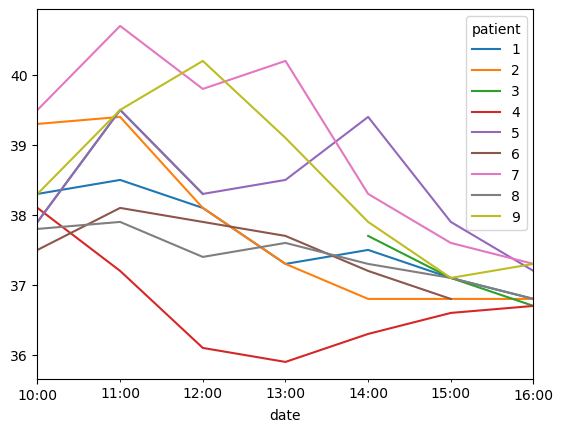

In [12]:
time_series.temperature.plot();

Hm, something seems fishy with the data for patient 3, let's visualize it individually.

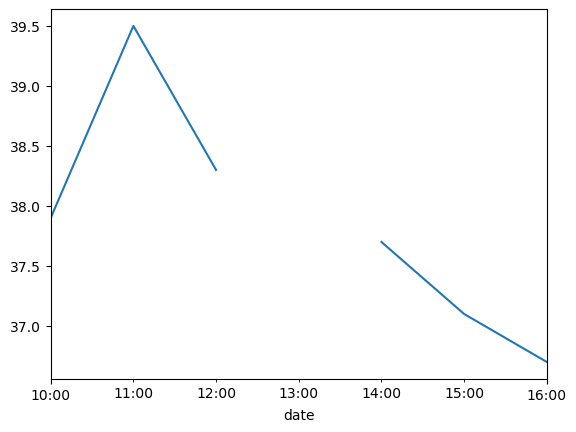

In [13]:
time_series.temperature[3].plot();

The temperature for patient 3 was not measured at 13:00:00, but the dose was recorded. Let's check for other missing data more systematically.

In [14]:
time_series.isnull().any(axis=1)

date
2012-10-02 10:00:00    False
2012-10-02 11:00:00    False
2012-10-02 12:00:00    False
2012-10-02 13:00:00     True
2012-10-02 14:00:00     True
2012-10-02 15:00:00    False
2012-10-02 16:00:00     True
dtype: bool

We should take a look at the measurements for 13:00:00 and 14:00:00.

In [15]:
time_series.loc['2012-10-02 13:00:00']

             patient
dose         1           2.0
             2           5.0
             3           2.0
             4           0.0
             5           5.0
             6           2.0
             7           8.0
             8           0.0
             9           4.0
temperature  1          37.3
             2          37.3
             3           NaN
             4          35.9
             5          38.5
             6          37.7
             7          40.2
             8          37.6
             9          39.1
Name: 2012-10-02 13:00:00, dtype: float64

This was the temperature we were aware of, but at 14:00:00, it seems the dose was not recorded for patient 4.

In [16]:
time_series.loc['2012-10-02 14:00:00']

             patient
dose         1           0.0
             2           0.0
             3           2.0
             4           NaN
             5           9.0
             6           1.0
             7           3.0
             8           0.0
             9           4.0
temperature  1          37.5
             2          36.8
             3          37.7
             4          36.3
             5          39.4
             6          37.2
             7          38.3
             8          37.3
             9          37.9
Name: 2012-10-02 14:00:00, dtype: float64

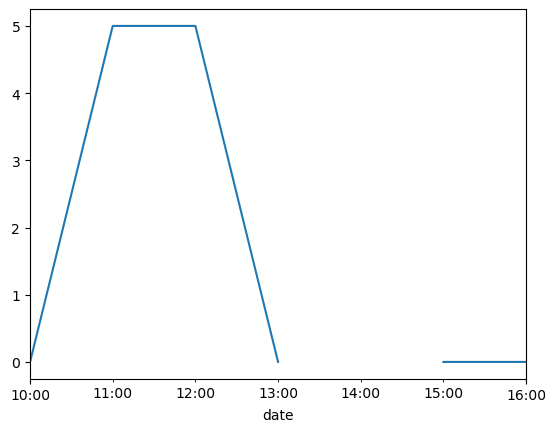

In [17]:
time_series.dose[4].plot();

From the plots, it seems reasonable to do a linear interpolation for both missing data points.

In [18]:
interpolated_3 = time_series.temperature[3].interpolate()
interpolated_4 = time_series.dose[4].interpolate()

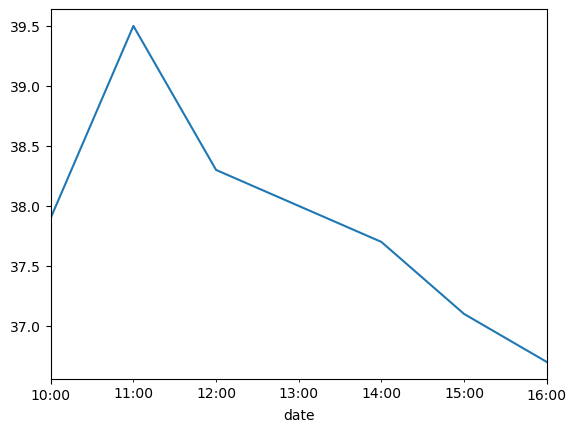

In [19]:
interpolated_3.plot();

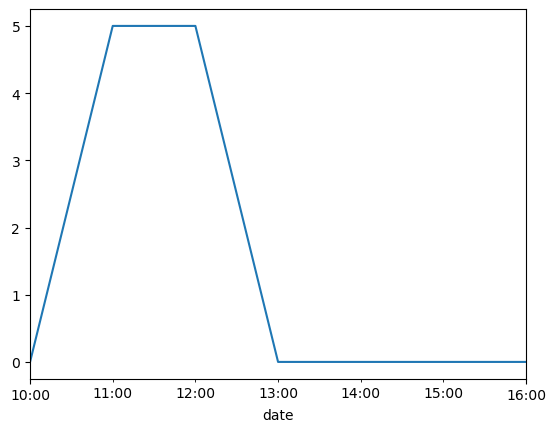

In [20]:
interpolated_4.plot();

Let's do the interpolation on the time series in place.

In [21]:
time_series.interpolate(inplace=True)

We should have no more missing data, let's verify.

In [22]:
time_series.isnull().any(axis=1)

date
2012-10-02 10:00:00    False
2012-10-02 11:00:00    False
2012-10-02 12:00:00    False
2012-10-02 13:00:00    False
2012-10-02 14:00:00    False
2012-10-02 15:00:00    False
2012-10-02 16:00:00    False
dtype: bool

Let's verify what happend for patient 6 with the missing data at the end of the experiment.

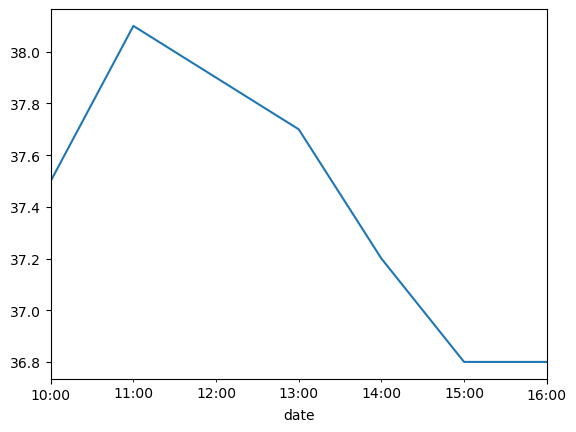

In [23]:
time_series.temperature[6].plot();

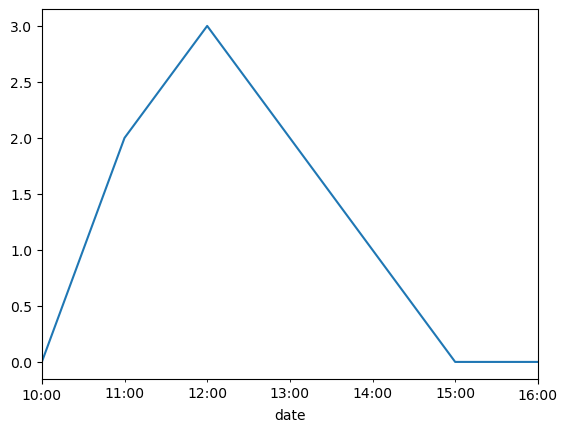

In [24]:
time_series.dose[6].plot();

The value is the same for 16h as for 15h, which is reasonable.

## Derived data

Let's add a new column to the time series that represents the average temperature over all patients.

In [25]:
time_series['avg_temp'] = time_series.temperature.mean(axis=1)

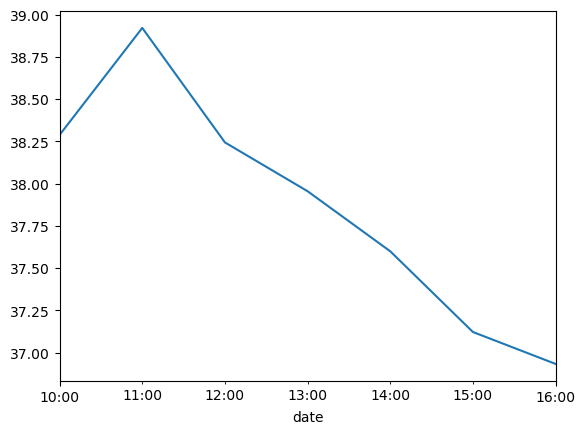

In [26]:
time_series.avg_temp.plot();

Let's also add a column for each patient that shows the cummulative dose for that patient.

In [27]:
for patient in time_series.dose.columns:
    cumm_dose = time_series.dose[patient].cumsum()
    time_series['cumm_dose', patient] = cumm_dose

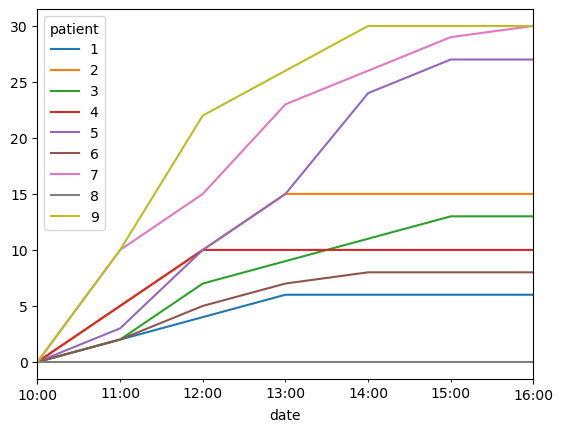

In [28]:
time_series.cumm_dose.plot();

Let's check the maximum temperature and the total dose per patient using a pivot table. We index by patient, while the values should be the dose and the temperature, aggregated as sum and maximum respectively.

In [29]:
hypothesis = experiment_data.pivot_table(index='patient',
                                         values=('dose', 'temperature',),
                                         aggfunc={
                                             'dose': 'sum',
                                             'temperature': 'max',
                                         })
hypothesis

,dose,temperature
patient,,
1,6.0,38.5
2,15.0,39.4
3,13.0,39.5
4,10.0,38.1
5,27.0,39.5
6,8.0,38.1
7,30.0,40.7
8,0.0,37.9
9,30.0,40.2


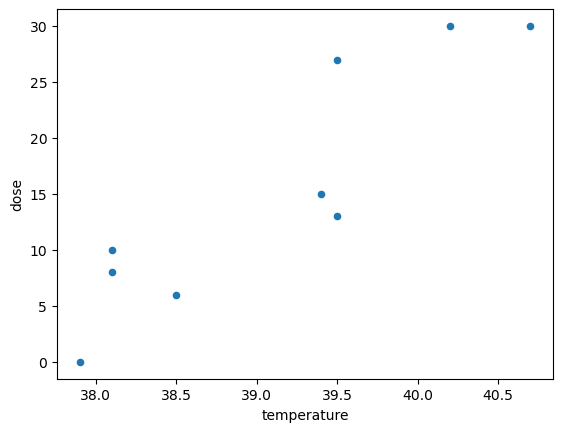

In [30]:
hypothesis.plot.scatter(x='temperature', y='dose',
                        marker='o');

It seems possible that there is a linear relationship between the maximum temperature, and the total dose administered during the experiment. Let's use Seaborn to copmute and display a linear regression on the data.

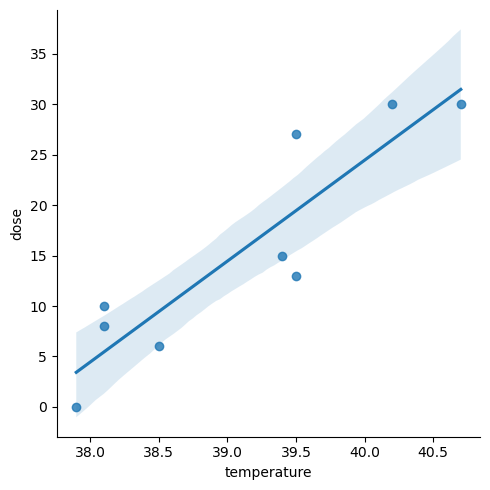

In [31]:
sns.lmplot(x='temperature', y='dose', data=hypothesis);

## Metadata

There is a second file with metadata on the patients, let's read that as well. The data is in de file `patient_metadata.xlsx`.

In [32]:
metadata = pd.read_excel('data/patient_metadata.xlsx')
metadata

,patient,gender,condition
0,1,M,A
1,2,F,A
2,3,M,A
3,5,M,A
4,6,F,B
5,7,M,B
6,8,F,B
7,9,M,B
8,10,F,B
9,11,M,B



How many distinct genders and conditions do we have?

In [33]:
for column in ['gender' ,'condition']:
    values = metadata[column].drop_duplicates().values
    print(column, ':', values, '->', len(values))

gender : ['M' 'F'] -> 2
condition : ['A' 'B'] -> 2


Gender and condition are categorical data, let's use `describe` on those columns.

In [34]:
metadata[['gender', 'condition']].describe()

,gender,condition
count,10,10
unique,2,2
top,M,B
freq,6,6


Which patients are male, and have condition A?

In [35]:
metadata.query('gender == "M" & condition == "A"')

,patient,gender,condition
0,1,M,A
2,3,M,A
3,5,M,A


## Merging dataframes

The patient IDs in the exerperimental and metadata should correspond, so let merge the dataframes. However, let's first check whether the patient IDs are the same in both dataframes.

In [36]:
patients_experiment = set(experiment_data.patient)
patients_metadata = set(metadata.patient)
print(patients_experiment - patients_metadata)
print(patients_metadata - patients_experiment)

{4}
{10, 11}


So metadata is missing for patient 4, and there is metadata for patients that were not involved in the experiment (10 and 11).  Since we are not interested in the latter, and should keep the data on patient 4 regardless of metadata, we do a left-join of the data of the experiment, and the metadata.

In [37]:
data = pd.merge(experiment_data, metadata, on='patient', how="left")
data

,patient,dose,date,temperature,gender,condition
0,1,0.0,2012-10-02 10:00:00,38.3,M,A
1,1,2.0,2012-10-02 11:00:00,38.5,M,A
2,1,2.0,2012-10-02 12:00:00,38.1,M,A
3,1,2.0,2012-10-02 13:00:00,37.3,M,A
4,1,0.0,2012-10-02 14:00:00,37.5,M,A
...,...,...,...,...,...,...
57,9,12.0,2012-10-02 12:00:00,40.2,M,B
58,9,4.0,2012-10-02 13:00:00,39.1,M,B
59,9,4.0,2012-10-02 14:00:00,37.9,M,B
60,9,0.0,2012-10-02 15:00:00,37.1,M,B


Since gender and condition are categorical data, we set the type appropriately.

In [38]:
data['gender'] = data.gender.astype('category')
data['condition'] = data.condition.astype('category')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient      62 non-null     int64         
 1   dose         61 non-null     float64       
 2   date         62 non-null     datetime64[ns]
 3   temperature  61 non-null     float64       
 4   gender       55 non-null     category      
 5   condition    55 non-null     category      
dtypes: category(2), datetime64[ns](1), float64(2), int64(1)
memory usage: 2.4 KB


In [40]:
data[['gender', 'condition']].describe()

,gender,condition
count,55,55
unique,2,2
top,M,A
freq,35,28


How many patients involved in our experiment are male, and how many female?

In [41]:
data[['patient', 'gender']] \
    .drop_duplicates() \
    .groupby('gender', observed=False).count()

,patient
gender,
F,3
M,5


Which patients had a temperature higher than $39^{\circ}$, and when?  Let's also display the gender.

In [42]:
data[['patient', 'date', 'temperature', 'gender']] \
    .query('temperature > 39.0')

,patient,date,temperature,gender
7,2,2012-10-02 10:00:00,39.3,F
8,2,2012-10-02 11:00:00,39.4,F
15,3,2012-10-02 11:00:00,39.5,M
29,5,2012-10-02 11:00:00,39.5,M
32,5,2012-10-02 14:00:00,39.4,M
41,7,2012-10-02 10:00:00,39.5,M
42,7,2012-10-02 11:00:00,40.7,M
43,7,2012-10-02 12:00:00,39.8,M
44,7,2012-10-02 13:00:00,40.2,M
56,9,2012-10-02 11:00:00,39.5,M


Suspiciously many males, let's see how many males versus females had a temperature (at any point).

In [43]:
data.query('temperature > 39.0')[['patient', 'gender']] \
    .drop_duplicates().groupby('gender', observed=False).count()

,patient
gender,
F,1
M,4


## Gender differences?

There might be a gender influence here. Let's split our data set into male and female patients.

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient      62 non-null     int64         
 1   dose         61 non-null     float64       
 2   date         62 non-null     datetime64[ns]
 3   temperature  61 non-null     float64       
 4   gender       55 non-null     category      
 5   condition    55 non-null     category      
dtypes: category(2), datetime64[ns](1), float64(2), int64(1)
memory usage: 2.4 KB


In [45]:
gender_series = data.pivot(index='date',
                                 columns=('gender', 'patient', ))
gender_series.temperature = gender_series.temperature.interpolate()
gender_series.dose = gender_series.dose.interpolate()
gender_series

dose                                            \
gender                 M    F    M  nan    M    F     M    F     M   
patient                1    2    3    4    5    6     7    8     9   
date                                                                 
2012-10-02 10:00:00  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
2012-10-02 11:00:00  2.0  5.0  2.0  5.0  3.0  2.0  10.0  0.0  10.0   
2012-10-02 12:00:00  2.0  5.0  5.0  5.0  7.0  3.0   5.0  0.0  12.0   
2012-10-02 13:00:00  2.0  5.0  2.0  0.0  5.0  2.0   8.0  0.0   4.0   
2012-10-02 14:00:00  0.0  0.0  2.0  0.0  9.0  1.0   3.0  0.0   4.0   
2012-10-02 15:00:00  0.0  0.0  2.0  0.0  3.0  0.0   3.0  0.0   0.0   
2012-10-02 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0   1.0  0.0   0.0   

                    temperature  ...       condition                           \
gender                        M  ...               M  F  M  nan  M    F  M  F   
patient                       1  ...     9         1  2  3    4  5    6  7  8   
date                             ...                                            
2012-10-02 10:00:00        38.3  ...  38.3         A  A  A  NaN  A    B  B  B   
2012-10-02 11:00:00        38.5  ...  39.5         A  A  A  NaN  A    B  B  B   
2012-10-02 12:00:00        38.1  ...  40.2         A  A  A  NaN  A    B  B  B   
2012-10-02 13:00:00        37.3  ...  39.1         A  A  A  NaN  A    B  B  B   
2012-10-02 14:00:00        37.5  ...  37.9         A  A  A  NaN  A    B  B  B   
2012-10-02 15:00:00        37.1  ...  37.1         A  A  A  NaN  A    B  B  B   
2012-10-02 16:00:00        36.8  ...  37.3         A  A  A  NaN  A  NaN  B  B   

                        
gender               M  
patient              9  
date                    
2012-10-02 10:00:00  B  
2012-10-02 11:00:00  B  
2012-10-02 12:00:00  B  
2012-10-02 13:00:00  B  
2012-10-02 14:00:00  B  
2012-10-02 15:00:00  B  
2012-10-02 16:00:00  B  

[7 rows x 27 columns]

Note that now the data for patient 4 is missing, since the gender is unknown.

Let's compute the average temperature for male and female patients, compare.

In [46]:
avg_male_temp = gender_series.temperature.M.mean(axis=1)
avg_female_temp = gender_series.temperature.F.mean(axis=1)

In [47]:
type(avg_male_temp)

pandas.core.series.Series

These are two `Series`, we can concatenate these into a single `DataFrame`.

In [48]:
temps = pd.concat([avg_male_temp, avg_female_temp],
                  axis=1)
temps.columns = ['male', 'female']
temps

,male,female
date,,
2012-10-02 10:00:00,38.38,38.200000
2012-10-02 11:00:00,39.54,38.466667
2012-10-02 12:00:00,38.94,37.800000
2012-10-02 13:00:00,38.62,37.533333
2012-10-02 14:00:00,38.16,37.100000
2012-10-02 15:00:00,37.36,36.900000
2012-10-02 16:00:00,37.06,36.800000


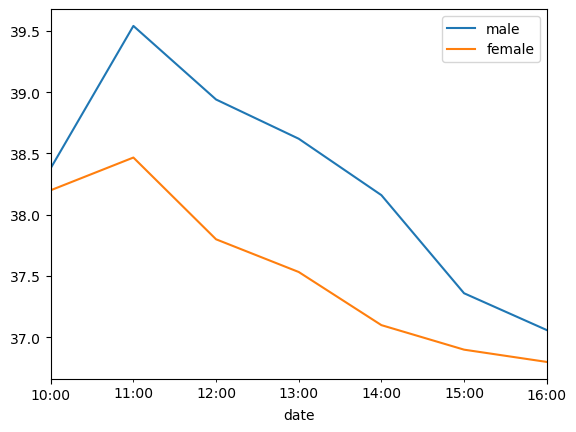

In [49]:
temps.plot();

Looks like we are on to something, pity this is not real data.

In [50]:
gender_hypothesis = data.pivot_table(index=['gender', 'patient'],
                                     values=['temperature', 'dose'],
                                     aggfunc={'temperature': 'max',
                                              'dose': 'sum'},
                                     observed=True)
gender_hypothesis

dose  temperature
gender patient                   
F      2        15.0         39.4
       6         8.0         38.1
       8         0.0         37.9
M      1         6.0         38.5
       3        13.0         39.5
       5        27.0         39.5
       7        30.0         40.7
       9        30.0         40.2

## Conditions

However, we didn't take the patients' condition into account yet. Let's check how many patients have a specific condition.

In [51]:
data[['patient', 'condition']] \
    .drop_duplicates() \
    .groupby('condition', observed=False) \
    .count()

,patient
condition,
A,4
B,4


What is the distribution of the condition with respect to the patients's gender?

In [52]:
data[['patient', 'condition', 'gender']] \
    .drop_duplicates() \
    .groupby(['condition', 'gender'], observed=False) \
    .count()

patient
condition gender         
A         F             1
          M             3
B         F             2
          M             2

This data can be conveniently visualized using a bar plot.

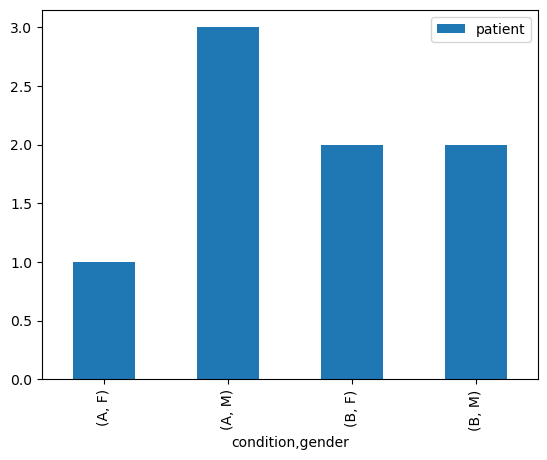

In [53]:
data[['patient', 'condition', 'gender']] \
    .drop_duplicates() \
    .groupby(['condition', 'gender'], observed=False) \
    .count().plot.bar();

## From numbers to categories

Let's create an extra column in the `DataFrame` that is categorical, and represents the status of the patients in terms of fever.

In [54]:
data['status'] = pd.cut(data.temperature,
                        bins=[35.5, 37.5, 39.0, 43.0],
                        labels=['normal', 'fever', 'high fever'])

In [55]:
data.head()

,patient,dose,date,temperature,gender,condition,status
0,1,0.0,2012-10-02 10:00:00,38.3,M,A,fever
1,1,2.0,2012-10-02 11:00:00,38.5,M,A,fever
2,1,2.0,2012-10-02 12:00:00,38.1,M,A,fever
3,1,2.0,2012-10-02 13:00:00,37.3,M,A,normal
4,1,0.0,2012-10-02 14:00:00,37.5,M,A,normal


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient      62 non-null     int64         
 1   dose         61 non-null     float64       
 2   date         62 non-null     datetime64[ns]
 3   temperature  61 non-null     float64       
 4   gender       55 non-null     category      
 5   condition    55 non-null     category      
 6   status       61 non-null     category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1)
memory usage: 2.6 KB


In [57]:
data.status.describe()

count         61
unique         3
top       normal
freq          27
Name: status, dtype: object

A similar query to the one we did before can now be done on the `status` attribute.

In [58]:
data.query('status == "high fever"')

,patient,dose,date,temperature,gender,condition,status
7,2,0.0,2012-10-02 10:00:00,39.3,F,A,high fever
8,2,5.0,2012-10-02 11:00:00,39.4,F,A,high fever
15,3,2.0,2012-10-02 11:00:00,39.5,M,A,high fever
29,5,3.0,2012-10-02 11:00:00,39.5,M,A,high fever
32,5,9.0,2012-10-02 14:00:00,39.4,M,A,high fever
41,7,0.0,2012-10-02 10:00:00,39.5,M,B,high fever
42,7,10.0,2012-10-02 11:00:00,40.7,M,B,high fever
43,7,5.0,2012-10-02 12:00:00,39.8,M,B,high fever
44,7,8.0,2012-10-02 13:00:00,40.2,M,B,high fever
56,9,10.0,2012-10-02 11:00:00,39.5,M,B,high fever


The patients with high fever are given by:

In [59]:
data[['patient', 'status']] \
    .query('status == "high fever"') \
    .drop_duplicates()['patient']

7     2
15    3
29    5
41    7
56    9
Name: patient, dtype: int64

This result is the same as for the query we performed earlier.